# Variability

In [1]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import scipy.stats
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import copy

# Required for interactive plots in DataSpell
# import matplotlib
# matplotlib.use("nbagg")

### Load data

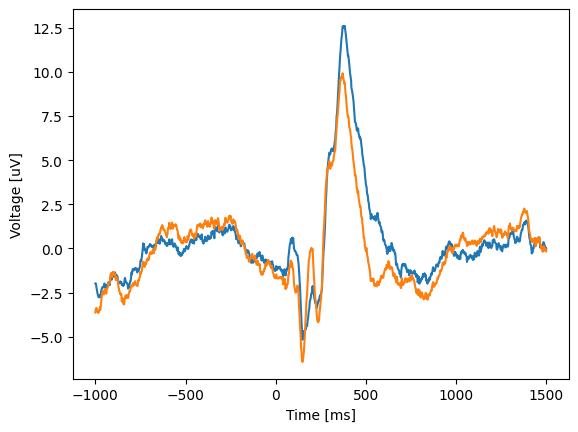

In [2]:
matdat = sio.loadmat('References/sigprocMXC_variability/SNRdata.mat')
timevec = np.squeeze( matdat['timevec'] )
eegdata = matdat['eegdata']
fs = 1000 / np.mean(np.diff(timevec))

plt.figure()
plt.plot(timevec, np.mean(eegdata,2).T)
plt.ylabel("Voltage [uV]")
plt.xlabel("Time [ms]")
plt.show()

### See how a low-pass filter affects the SNR

First, create a helper function to filter the data

In [4]:
# Long kernel size
def lpfilter_sinc(data: np.ndarray, cutoff, fs, plot: bool=False) -> np.ndarray:

    sideTime = 0.5
    time = np.arange(-sideTime, sideTime, 1 / fs)
    n = len(time)

    # create sinc function
    sincfilt = np.sin(2*np.pi*cutoff*time) / time

    # adjust NaN and normalize filter to unit-gain
    sincfilt[np.isnan(sincfilt)] = np.nanmax(sincfilt)
    sincfilt = sincfilt / np.sum(sincfilt)

    # windowed sinc filter
    sincfiltW = sincfilt * np.hanning(n)

    # Reflect data
    reflectedData = np.concatenate((np.flip(data), data, np.flip(data)))

    # Apply filter
    filteredData = signal.filtfilt(sincfiltW, 1, reflectedData)

    # Remove reflection
    filteredData = filteredData[data.size:-data.size]

    if plot:
        plt.subplot(121)
        plt.plot(time,sincfilt,'k')
        plt.xlabel('Time (s)')
        plt.title('Non-windowed sinc function')

        plt.subplot(122)
        hz = np.linspace(0, fs/2, int(np.floor(n/2)+1))
        pw = np.abs(scipy.fftpack.fft(sincfilt))
        plt.plot(hz, pw[:len(hz)],'k')
        plt.xlim([0, cutoff*3])
        plt.yscale('log')
        plt.plot([cutoff, cutoff],[0,1],'r--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.show()

    return filteredData

# Smaller kernel, gaussian filtering, seems to filter too agressive
def lpfilter_gaus(data: np.ndarray, cutoff, fs, plot: bool=False) -> np.ndarray:

    ## create Gaussian spectral shape
    # Gaussian parameters (in Hz)
    peakf = 0               # Peak at 0Hz
    fwhm  = cutoff * 2      # cutoff at 0.5 gain

    # vector of frequencies
    hz = np.linspace(0, fs, data.size)

    # frequency-domain Gaussian
    s  = fwhm*(2*np.pi-1)/(4*np.pi)             # normalized width
    x  = hz-peakf                               # shifted frequencies
    kernelFFT = np.exp(-.5*(x/s)**2)            # gaussian

    ## Apply filter
    # 1st get the fft
    signalFFT = np.fft.fft(data)

    # 2nd multiply
    filteredData = signalFFT * kernelFFT

    # Finally, inverse fft
    filteredData = np.real(np.fft.ifft(filteredData))   ## DONT NEED TO MULTIPLY BY 2 ANYMORE (why?)

    if plot:
        plt.subplot(121)
        plt.plot(hz, kernelFFT)
        plt.xlim(0, cutoff * 2)
        plt.vlines(cutoff, 0, 1, color='red', linestyle='dashed')
        plt.ylabel("Gain")
        plt.xlabel("Frequency [Hz]")

        plt.subplot(122)
        plt.plot(data)
        plt.plot(filteredData)

    return filteredData

# Traditional filtering
def lpfilter(data: np.ndarray, cutoff, fs, plot: bool=False) -> np.ndarray:
    nyquist = fs/2
    order   = int( 10*fs/cutoff ) - 1 # Need one less for lower frequencies

    # force odd order
    if order%2==0:
        order += 1

    # filter kernel
    filtkern = signal.firwin(order, cutoff, fs=fs, pass_zero="lowpass")

    # Reflect data
    reflectedData = np.concatenate((np.flip(data), data, np.flip(data)))

    # Apply filter
    filteredData = signal.filtfilt(filtkern, 1, reflectedData)

    # Remove reflection
    filteredData = filteredData[data.size:-data.size]

    if plot:
        # time-domain filter kernel
        plt.plot(filtkern)
        plt.xlabel('Time points')
        plt.title('Filter kernel (firwin)')
        plt.show()

        # compute the power spectrum of the filter kernel
        filtpow = np.abs(scipy.fftpack.fft(filtkern))**2
        # compute the frequencies vector and remove negative frequencies
        hz      = np.linspace(0, fs/2,int(np.floor(len(filtkern)/2)+1))
        filtpow = filtpow[0:len(hz)]

        # plot amplitude spectrum of the filter kernel
        plt.plot(hz,filtpow,'ks-',label='Actual')
        plt.plot([0, cutoff, cutoff, nyquist], [1,1,0,0],'ro-',label='Ideal')
        plt.xlim([0, cutoff*4])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Filter gain')
        plt.legend()
        plt.title('Frequency response of filter (firwin)')
        plt.show()

        plt.figure()
        plt.plot(data)
        plt.plot(filteredData)

    return filteredData

# _ = lpfilter(np.ones(1281), 15, fs, plot=True)

Now, loop over different cutoff frequencies and see how filtering affects the results

C:\Users\lucan\AppData\Local\Temp\ipykernel_9784\3408288018.py:9: RuntimeWarning: invalid value encountered in divide
  sincfilt = np.sin(2*np.pi*cutoff*time) / time


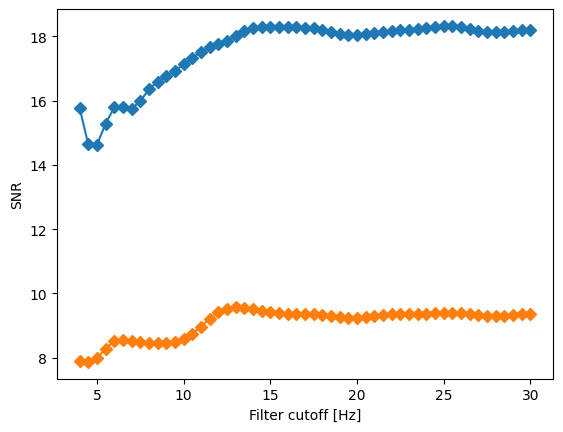

In [11]:
# pick time point
timepoint = 375
basetime  = [-500, 0]

freqs = np.arange(4, 30.5, 0.5)

# Average over repetitions
erp = np.mean(eegdata, 2)
bidx1 = np.argmin((timevec-basetime[0])**2)
bidx2 = np.argmin((timevec-basetime[1])**2)

snrs = [[], []]
erpf = copy.deepcopy(erp)
for freq in freqs:
    ## Filter data
    # Sinc function
    erpf[0] = lpfilter_sinc(erp[0], freq, fs)
    erpf[1] = lpfilter_sinc(erp[1], freq, fs)

    # Gaussian lp filter (does not work, filters too agressive)
    # erpf[0] = lpfilter_gaus(erp[0], freq, fs, True)
    # erpf[1] = lpfilter_gaus(erp[1], freq, fs)

    # Traditional FIR filter
    # erpf[0] = lpfilter(erp[0], freq, fs)
    # erpf[1] = lpfilter(erp[1], freq, fs)

    # SNR components
    snr_num = erpf[:,np.argmin((timevec-timepoint)**2)]
    snr_den = np.std( erpf[:,range(bidx1,bidx2)] ,1)

    # Save iteration
    snrs[0].append(snr_num[0]/snr_den[0])
    snrs[1].append(snr_num[1]/snr_den[1])

plt.figure()
plt.plot(freqs, snrs[0], marker='D', label='Channel 1')
plt.plot(freqs, snrs[1], marker='D', label='Channel 2')
plt.xlabel("Filter cutoff [Hz]")
plt.ylabel("SNR")
plt.show()